**Francis O'Hara**

CS 251: Data Analysis and Visualization

Fall 2024

# Project 6 | Extension

## Extension 1: Classifying own datset using Naive Bayes and KNN
The goal of this extension is to determine whether theNaive Bayes and KNN classifiers implemented in this project are good enough to be used for sentiment analysis of text.  

To implement this extension, I made use of the [Twitter Emotion Classification Dataset](https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset) available on Kaggle.

The dataset consists of English language twitter messages categorized into six basic emotions: `anger`, `fear`, `joy`, `love`, `sadness`, and `surprise`.  

I selected this dataset because, like the Enron email dataset, it can be preprocessed into numeric fields with frequency counts representing the number of times particular words appear in an observation (tweet), which makes it suitable for use by our Naive Bayes classifier.  
The labels also denote the emotions associated with each observation, hence making it suitable for sentiment analysis.

## A Note on Google Colab
Due to the sheer size of the dataset and consequently the amount of computation required for this extension, I decided to execute this notebook in a Google Colab environment so I could make use of the free GPU offerings on Google Colab for accelerated computing.  

As a result, all the files for my extension needed to be uploaded to a Google Drive folder publicly available at [this link](https://drive.google.com/drive/folders/1wMf7uQsGCsaO2w5Q0g82-31ZsE9ISSV6?usp=drive_link).

The code snippet below is required for Google Colab to access this Google Drive folder and sets the folder as the project directory so that modules and data files can be imported from it.

To replicate this environment, one must download the `extension` Google drive folder provided in the link above (or in the ZIP Archive I submitted for project 6), upload it to an appropriate location on a personal Google Drive, and replace the `path` variable in the code snippet below with the path to the uploaded `extension` directory on one's personal Google Drive.

In [2]:
from google.colab import drive
import os

drive.mount("/content/drive")

# replace with path to uploaded `extension` directory on your Google Drive.
path = "COLLEGE/Fall 2024/CS251/CS251/project_6/extension"

os.chdir(f"/content/drive/My Drive/{path}")

# confirm contents of current directory
print(f"Contents:\n {os.listdir()}")

Mounted at /content/drive
Contents:
 ['data', 'naive_bayes.py', 'classifier.py', 'knn.py', 'email_preprocessor.py', '__pycache__', 'project_6_extension.ipynb']


## A Note on CuPy
The following steps were taken to make full use of the GPUs available in the Google Colab environment for accelerated computing:
  ### 1. Change the runtime type in Google Colab from `CPU` to either `T4 GPU` (free), `L4 GPU` (paid) or `A100 GPU` (paid).

  The code snippet below displays information about the runtime type currently in use:

In [ ]:
!nvidia-smi

Mon Dec  2 14:15:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

The above cell's output indicates that we are currently using an Nvidia A100 Tensor Core GPU with about 40GB of RAM.

  
  ### 2. Use the [CuPy Python library](https://cupy.dev/) in place of NumPy.  
  In order to actually make use of the GPU runtime for performing the array computations in our project, we use CuPy, an open-source Python library for GPU-accelerated computing.  

  CuPy has the exact same interfaces as NumPy but leverages the parallel processing capabilities of the GPU architecture for performing array operations such as element-wise arithmetic, array slicing, matrix multiplication, etc. much more quickly than NumPy can.  

  Since both the KNN and Naive Bayes models we implemented in project 6 were done using NumPy arrays, CuPy will be used where necessary to accelerate computing during model training and prediction.

  The CuPy library is pre-installed in Google Colab environments and the code snippet below is used to import it:

In [ ]:
import cupy as cp

### Task 0: Read the dataset
Since the dataset is only available as an [Apache Parquet](https://parquet.apache.org/docs/overview/) file, the `Pandas` library is used to read it as a dataframe.

In [ ]:
# install package dependencies that Pandas needs to read parquet files
!pip install pyarrow
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.0 MB/s eta 0:00:00


In [3]:
# import all packages required for the project
import pandas as pd
import numpy as np
import re
import random
from naive_bayes import NaiveBayes
from knn import KNN
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_parquet("https://github.com/francisohara24/CS251/raw/1191d308160f33540f10341b7dbe9bbd5e5b2371/project_6/extension/data/twitter_emotion_classification_dataset.parquet")
print(f"{data.shape=}")
data.head()

data.shape=(416809, 2)


,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


From the above code cell output, the dataset consists of 416,809 tweets stored in the `text` column, with each tweet labelled with a number in the `label` column between 0 and 5 denoting the emotion expressed by the tweet.

The following are the emotions associated with each number:  
0: sadness  
1: joy  
2: love  
3: anger  
4: fear  
5: surprise  

### Task 1: Preprocessing the dataset for Naive Bayes.
The dataset will be preprocessed into a numpy array where each row represents a tweet and each feature stores the number of times a specific word appears in the tweet.

To do this, we will:  
 1. Find all unique words across the dataset and their frequency counts.
 2. Sort the unique words from most frequently occcuring to least frequently occuring.
 3. Store first 1000 most frequently occurring unique words.
 4. For each tweet, find the frequency count of each of the first 1000 most frequent unique words in the tweet.

 **NB:** CuPy is not being used at this stage as the computations being performed here do not contain a lot of NumPy array operations.  
 Using CuPy here may actually result in decreased performance.

In [ ]:
unique_words = {}

for i in range(data.shape[0]):
    tweet = data.loc[i]["text"]
    words = re.findall(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*', tweet.lower())

    for word in words:
        unique_words[word] = unique_words.get(word, 0) + 1

# sort and select 1000 most frequently occurring words
most_frequent = {key: value for key, value in sorted(unique_words.items(), key=lambda item: item[1], reverse=True)[:1000]}

print(f"unique words:\n {unique_words}")
print(f"number of unique words: {len(unique_words)}")
print(f"1000 most frequent unique words: {most_frequent}")

unique words:
 {'i': 676203, 'feel': 289939, 'awful': 1705, 'about': 46276, 'it': 84465, 'too': 11561, 'because': 30180, 's': 13139, 'my': 111199, 'job': 2525, 'to': 233106, 'get': 19571, 'him': 13906, 'in': 86434, 'a': 162914, 'position': 622, 'succeed': 138, 'and': 250279, 'just': 36942, 'didn': 3323, 't': 24193, 'happen': 1531, 'here': 7491, 'im': 61662, 'alone': 4017, 'ive': 14866, 'probably': 2648, 'mentioned': 490, 'this': 54622, 'before': 5767, 'but': 58592, 'really': 25862, 'do': 27830, 'proud': 2090, 'of': 129993, 'myself': 21668, 'for': 64050, 'actually': 5537, 'keeping': 661, 'up': 24373, 'with': 53030, 'new': 5426, 'years': 3919, 'resolution': 68, 'monthly': 57, 'weekly': 110, 'goals': 409, 'was': 57557, 'feeling': 134185, 'little': 19193, 'low': 1969, 'few': 5081, 'days': 5872, 'back': 10247, 'beleive': 9, 'that': 130733, 'am': 54541, 'much': 14426, 'more': 30072, 'sensitive': 305, 'other': 8791, 'peoples': 416, 'feelings': 8582, 'tend': 864, 'be': 46827, 'compassionate': 

In [ ]:
x = np.ndarray(shape=(data.shape[0], len(most_frequent)))
y = np.array(data["label"])

for i in range(data.shape[0]):
    tweet = data.iloc[i]["text"]
    words = re.findall(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*', tweet.lower())

    for j, word in enumerate(most_frequent):
        x[i, j] = words.count(word)

print(f"First 5 observations in x:\n {x[:5, :]}")
print(f"First 5 labels in y:\n {y[:5]}")

First 5 observations in x:
 [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [2. 0. 1. ... 0. 0. 0.]]
First 5 labels in y:
 [0 0 1 0 2]


The following steps will rely heavily on NumPy array operations.  
Hence CuPy will be used from here on out to accelarate computing.

**NB:** In addition to the below step, all project 6 modules in which NumPy arrays are used were replaced with CuPy.  
That is, `classifier.py`, `knn.py`, and `naive_bayes.py` have their import statements modified from
```python
import numpy as np
```
to
```python
import cupy as np
```

In [ ]:
# convert numpy arrays to cupy
x = cp.array(x)
y = cp.array(y)

### Task 2: Splitting the dataset into training and testing datasets
The proportion of datapoints used for testing will be 0.2.
The datapoints will also be shuffled before the train-test split to avoid potential bias.

In [ ]:
# shuffle the dataset
random.seed(42)

indices = list(np.arange(len(y)))
shuffled_indices = np.zeros(shape=(len(y),), dtype=int)

for i in range(shuffled_indices.shape[0]):
    random_index = random.randint(0, len(indices) - 1)
    shuffled_indices[i] = indices.pop(random_index)

print(f"{shuffled_indices=}")
print(f"{shuffled_indices.shape=}")

shuffled_indices=array([335243,  58369,  13112, ..., 171274, 215882, 187710])
shuffled_indices.shape=(416809,)


In [ ]:
# perform train-test split
test_size = y.shape[0] // 5
test_indices = shuffled_indices[:test_size]
train_indices  = shuffled_indices[test_size:]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test  = y[test_indices]

### Task 3: Performing Naives Bayes Classification

In [ ]:
nb_classifier = NaiveBayes(num_classes=6)
nb_classifier.train(x_train, y_train)

y_pred = nb_classifier.predict(x_test)
nb_accuracy = nb_classifier.accuracy(y_test, y_pred)
nb_conf_matrix = nb_classifier.confusion_matrix(y_test, y_pred)

print(f"Naive Bayes Classifier Accuracy:\n{nb_accuracy}")
print(f"Naive Bayes Classifier Confusion Matrix:\n{nb_conf_matrix}")

Naive Bayes Classifier Accuracy:
0.8473746716090258
Naive Bayes Classifier Confusion Matrix:
[[2.2039e+04 1.1350e+03 1.7700e+02 5.8200e+02 3.3700e+02 5.4000e+01]
 [1.0860e+03 2.5458e+04 1.1200e+03 2.4200e+02 2.3000e+02 1.5300e+02]
 [2.4500e+02 1.4690e+03 4.9230e+03 1.0800e+02 4.8000e+01 1.6000e+01]
 [1.0440e+03 9.1500e+02 1.3900e+02 8.9220e+03 3.3200e+02 3.8000e+01]
 [8.2800e+02 6.6500e+02 5.5000e+01 3.8600e+02 7.2100e+03 4.2000e+02]
 [1.1100e+02 3.3700e+02 2.9000e+01 2.4000e+01 3.9800e+02 2.0860e+03]]


### Task 4: Performing KNN Classification
The KNN prediction step is the most computationally intensive task among all tasks in this extension.

Hence to get a good sense of how long it would take for the model to predict classes for all datapoints, I modified the `KNN.predict()` method in `knn.py` so that it prints out the estimated duration as well as the number of datapoints that have been classified so far out of the total number of datapoints to be classified.  
The output for the code cell below provides this information:

In [ ]:
knn_classifier = KNN(num_classes=6)
knn_classifier.train(x_train, y_train)

y_pred = knn_classifier.predict(x_test, 5)
knn_accuracy = knn_classifier.accuracy(y_test, y_pred)
knn_conf_matrix = knn_classifier.confusion_matrix(y_test, y_pred)

Streaming output truncated to the last 5000 lines.
78361/83361
78362/83361
78363/83361
78364/83361
78365/83361
78366/83361
78367/83361
78368/83361
78369/83361
78370/83361
78371/83361
78372/83361
78373/83361
78374/83361
78375/83361
78376/83361
78377/83361
78378/83361
78379/83361
78380/83361
78381/83361
78382/83361
78383/83361
78384/83361
78385/83361
78386/83361
78387/83361
78388/83361
78389/83361
78390/83361
78391/83361
78392/83361
78393/83361
78394/83361
78395/83361
78396/83361
78397/83361
78398/83361
78399/83361
78400/83361
78401/83361
78402/83361
78403/83361
78404/83361
78405/83361
78406/83361
78407/83361
78408/83361
78409/83361
78410/83361
78411/83361
78412/83361
78413/83361
78414/83361
78415/83361
78416/83361
78417/83361
78418/83361
78419/83361
78420/83361
78421/83361
78422/83361
78423/83361
78424/83361
78425/83361
78426/83361
78427/83361
78428/83361
78429/83361
78430/83361
78431/83361
78432/83361
78433/83361
78434/83361
78435/83361
78436/83361
78437/83361
78438/83361
78439/83361
7

In [ ]:
print(f"KNN Classifier Accuracy:\n{knn_accuracy}")
print(f"KNN Classifier Confusion Matrix:\n{knn_conf_matrix}")

KNN Classifier Accuracy:
0.4571442281162654
KNN Classifier Confusion Matrix:
[[10693.  7246.   731.  2866.  2394.   394.]
 [ 3384. 18070.  1847.  2466.  2070.   452.]
 [  879.  3055.  1532.   656.   583.   104.]
 [ 2145.  3315.   352.  4013.  1388.   177.]
 [ 1753.  2625.   302.  1151.  3240.   493.]
 [  419.  1059.    78.   270.   599.   560.]]


### Task 5: Better Confusion Matrix Visualization
To better understand which emotions specifically are being confused for which other emotions, I created a better visualization of the confusion matrix for both Naive Bayes and KNN below.

In [10]:
def visualize_confusion_matrix(confusion_matrix, labels, title):
    """Visualize the confusion matrix that results after classification.

    Parameters
    ----------
    confusion_matrix : np.ndarray; shape=(num_labels, num_labels)
        The confusion matrix after classification represented as a numpy ndarray of integers.

    labels : list[str]; shape=(num_labels,)
        The string class names associated with each label of the classification dataset.
        For example, if label 0 is associated with the class "sadness" then `labels[0]` must equal the string `"sadness"`.

    title : str
        The title of the visualization.
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(confusion_matrix, cmap="viridis")
    plt.colorbar(im)

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    ax.grid(False)
    plt.show()

Since `matplotlib` works with NumPy arrays, the confusion matrices must be converted from CuPy arrays into NumPy arrays before visualization.

In [ ]:
nb_conf_matrix = cp.asnumpy(nb_conf_matrix)
knn_conf_matrix = cp.asnumpy(knn_conf_matrix)

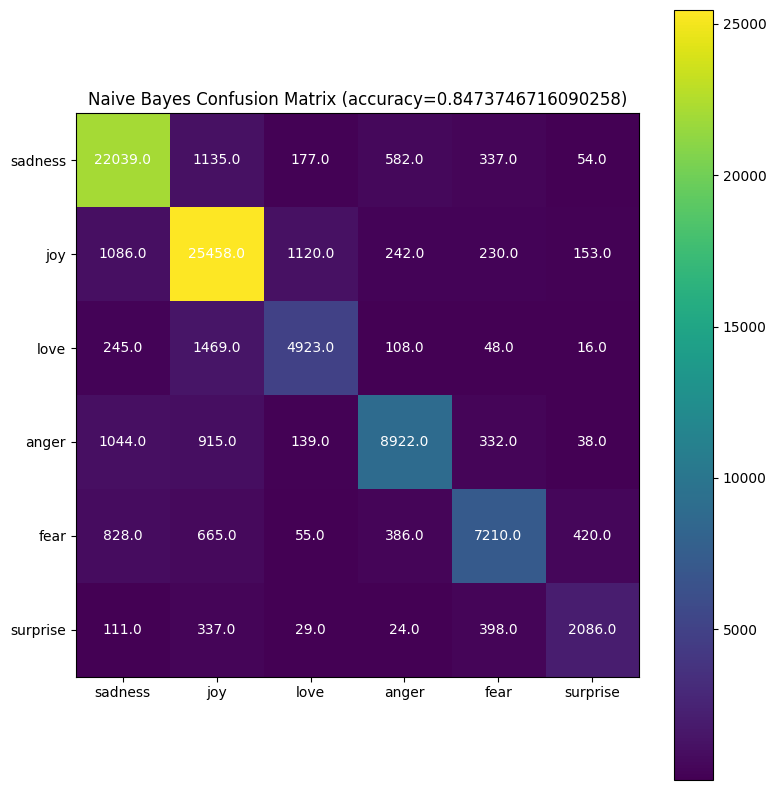

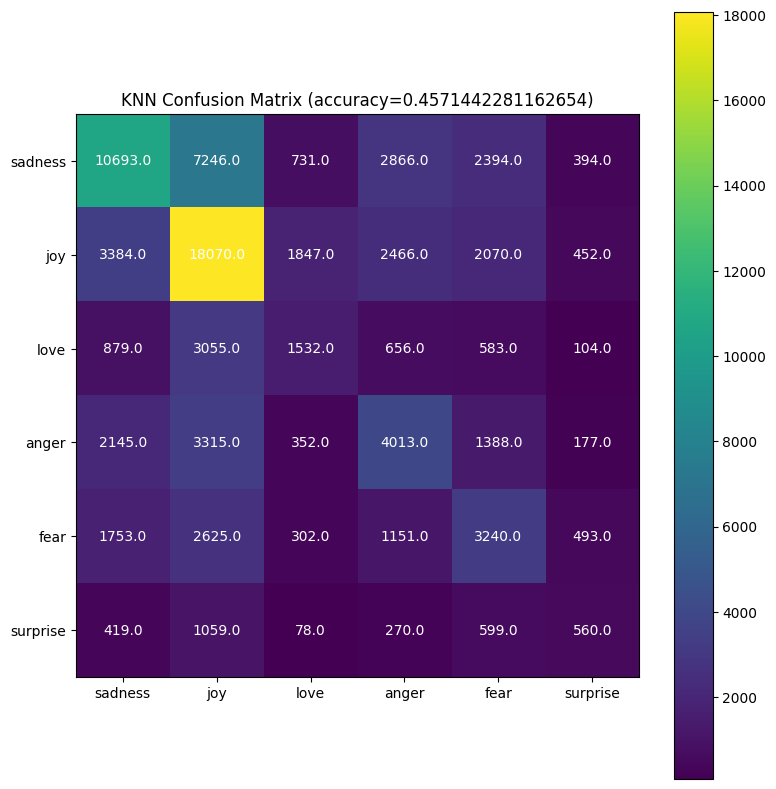

In [ ]:
visualize_confusion_matrix(nb_conf_matrix, ["sadness", "joy", "love", "anger", "fear", "surprise"], f"Naive Bayes Confusion Matrix (accuracy={nb_accuracy})")
visualize_confusion_matrix(knn_conf_matrix, ["sadness", "joy", "love", "anger", "fear", "surprise"], f"KNN Confusion Matrix (accuracy={knn_accuracy})")

### Observations and Conclusion
The Naive Bayes classifier achieved an accuracy of about $84\%$, indicating that the model was relatively great at predicting the emotion being expressed based on the words in each tweet.
Despite the relatively great accuracy, the Naive Bayes model was prone to misclassifying a lot of the emotions as being other emotions such as misclassifying love as joy and joy as love; joy as sadness and sadness as joy. It was also prone to misclassifying anger as sadness to a higher degree than it misclassified sadness as joy.


The KNN classifier, unlike the Naive Bayes classifier, achieved a relatively low accuracy of about $46\%$.
I suspect it would be able to achieve a much higher accuracy if the neighborhood size $k$ were larger.  
I settled on a neighborhood size of $k=5$ due to the fact that KNN prediction was extremely computationally intensive and took several minutes to compute even on the Nvidia A100 GPU.

Overall, this extension at least proves that the Naive Bayes classifier implemented in project 6 can indeed be used for sentiment analysis of text and is more computationally efficient at such tasks than classifiers such as K Nearest Neighbors.

## Extension 2: Better text preprocessing
When implementing the text preprocessor for this project, we simply focused on the 200 most frequently encountered words in the Enron email dataset.  
Most of these frequently encountered words are inconsequential to whether or not an email will be classified as spam or ham and are simply words that are frequently encountered in the English language because they are required to maintain grammatical structure. For example, the words "is", "the", "and", "are", etc. are neutral words and don't necessarily have any bearing on whether or not an email should be classified as ham or spam.  
Hence, in this extension, we will improve upon the text preprocessing pipeline, by filtering out these [stop words](https://en.wikipedia.org/wiki/Stop_word), and seeing if this has any effect on model accuracy.

The main tasks for this extension are:  
    1. Implement `smarter_count_words()`, an improved version of `email_preprocessor.count_words()` that filters out stop words.  
    2. Execute the email preprocessing pipeline replacing the call to `count_words()` with the call to `smarter_count_words()`.  
    3. Train KNN and Naive Bayes models on the preprocessed data and observe model performance for any changes.  

### Task 1: Implement `smarter_count_words()`
The [Python Natural Language Toolkit (NLTK)](https://www.nltk.org/) package provides a list of stop words that are usually filtered out during natural langauge processing tasks and will be used to implement `smarter_count_words()`.

In [1]:
# install required libraries
!pip install nltk


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# import required libraries
import nltk
from nltk.corpus import stopwords as sw
import email_preprocessor as epp

In [3]:
# retrieve stopwords from nltk package
nltk.download("stopwords")
stopwords = sw.words("english")
print(f"NLTK Stop Words:\n {stopwords}")

NLTK Stop Words:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francisohara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# implement smarter_count_words()
def smarter_count_words(email_path='data/enron/'):
    '''Determine the count of each word in the entire dataset (across all emails) making sure to exclude stop words from the NLTK list of stop words.

    Parameters:
    -----------
    email_path: str. Relative path to the email dataset base folder.

    Returns:
    -----------
    word_freq: Python dictionary. Maps words (keys) to their counts (values) across the dataset.
    num_emails: int. Total number of emails in the dataset.

    TODO:
    - Descend into the dataset base directory -> class folders -> individual emails.
    - Read each email file as a string.
    - Use the `tokenize_words` function above to chunk it into a list of words.
    - Update the counts of each word in the dictionary.

    Hints:
    - Check out Python functions in the os and os.path modules for walking the directory structure.
    '''
    num_emails = 0
    word_freq = {}

    for path in [f"{email_path}spam/", f"{email_path}ham/"]:
        for email in os.listdir(path):
            if email.endswith(".txt"):
                num_emails += 1
                words = epp.tokenize_words(open(path+email).read())
                for word in words:
                  if word in stopwords:
                    continue
                  word_freq[word] = word_freq.get(word, 0) + 1

    return word_freq, num_emails

### Task 2) Execute email preprocessing pipeline with `smarter_count_words()`

In [8]:
word_freq, num_emails = smarter_count_words()
top_words, counts = epp.find_top_words(word_freq)
feats, y = epp.make_feature_vectors(top_words, num_emails)

# perform train-test split
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(feats, y)

# store datasets for future use
np.save("data/x_train.npy", x_train)
np.save("data/y_train.npy", y_train)
np.save("data/inds_train.npy", inds_train)
np.save("data/x_test.npy", x_test)
np.save("data/y_test.npy", y_test)
np.save("data/inds_test.npy", inds_test)

### Task 3.1) Train Naive Bayes model on the preprocessed dataset.

To mimic the same conditions underwhich the original data preprocessing pipeline was executed, the random number generator will be seeded with the value it was previously seeded with of $0$:

In [19]:
np.random.seed(0)

In [20]:
nb_classifier = NaiveBayes(num_classes=2)
nb_classifier.train(x_train, y_train)
y_pred = nb_classifier.predict(x_test)
nb_accuracy = nb_classifier.accuracy(y_test, y_pred)
nb_conf_matrix = nb_classifier.confusion_matrix(y_test, y_pred)

print(f"Naive Bayes Classifier Accuracy: {nb_accuracy}")
print(f"Naive Bayes Classifier Confusion Matrix:\n {nb_conf_matrix}")

Naive Bayes Classifier Accuracy: 0.925846483836372
Naive Bayes Classifier Confusion Matrix:
 [[2895.  373.]
 [ 111. 3148.]]


### Task 3.2) Train KNN model on preprocecssed dataset.

In [21]:
knn_classifier = KNN(num_classes=2)
knn_classifier.train(x_train, y_train)
y_pred = knn_classifier.predict(x_test, 10)
knn_accuracy = knn_classifier.accuracy(y_test, y_pred)
knn_conf_matrix = knn_classifier.confusion_matrix(y_test, y_pred)

print(f"KNN Classifier Accuracy: {knn_accuracy}")
print(f"KNN Classifier Confusion Matrix:\n {knn_conf_matrix}")

It will take approximately 214.15069222450256 seconds for the KNN model to predict the classes for all 6527 observations in the dataset.
Progress:

0/6527
1/6527
2/6527
3/6527
4/6527
5/6527
6/6527
7/6527
8/6527
9/6527
10/6527
11/6527
12/6527
13/6527
14/6527
15/6527
16/6527
17/6527
18/6527
19/6527
20/6527
21/6527
22/6527
23/6527
24/6527
25/6527
26/6527
27/6527
28/6527
29/6527
30/6527
31/6527
32/6527
33/6527
34/6527
35/6527
36/6527
37/6527
38/6527
39/6527
40/6527
41/6527
42/6527
43/6527
44/6527
45/6527
46/6527
47/6527
48/6527
49/6527
50/6527
51/6527
52/6527
53/6527
54/6527
55/6527
56/6527
57/6527
58/6527
59/6527
60/6527
61/6527
62/6527
63/6527
64/6527
65/6527
66/6527
67/6527
68/6527
69/6527
70/6527
71/6527
72/6527
73/6527
74/6527
75/6527
76/6527
77/6527
78/6527
79/6527
80/6527
81/6527
82/6527
83/6527
84/6527
85/6527
86/6527
87/6527
88/6527
89/6527
90/6527
91/6527
92/6527
93/6527
94/6527
95/6527
96/6527
97/6527
98/6527
99/6527
100/6527
101/6527
102/6527
103/6527
104/6527
105/6527
106/6527

### Task 3.3) Visualize Model Performance
Here we make use of the `visualize_confusion_matrix()` method defined in extension 1 to visualize model performance

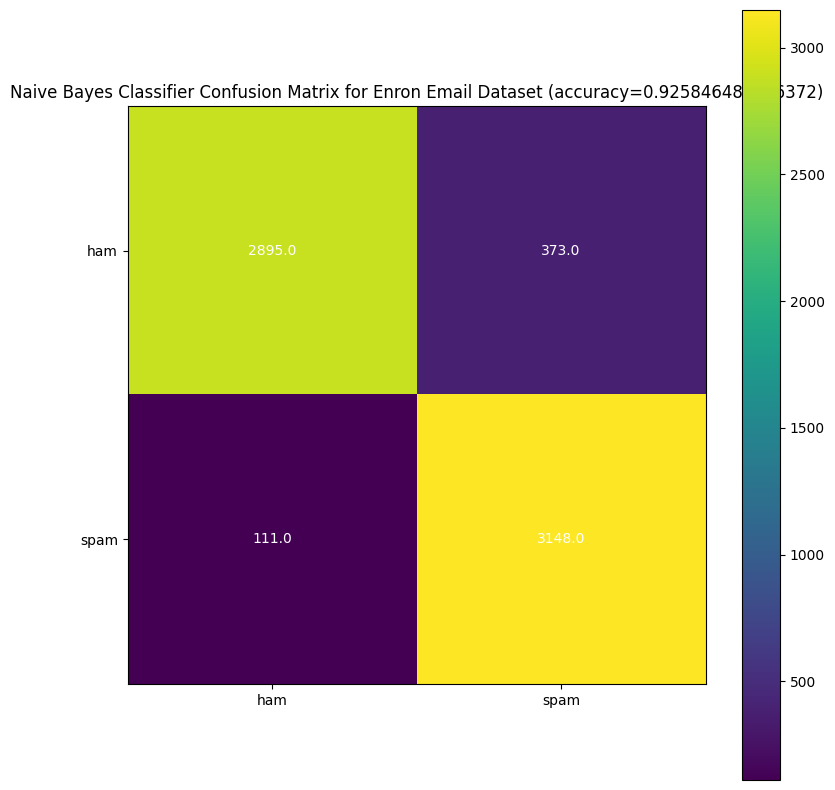

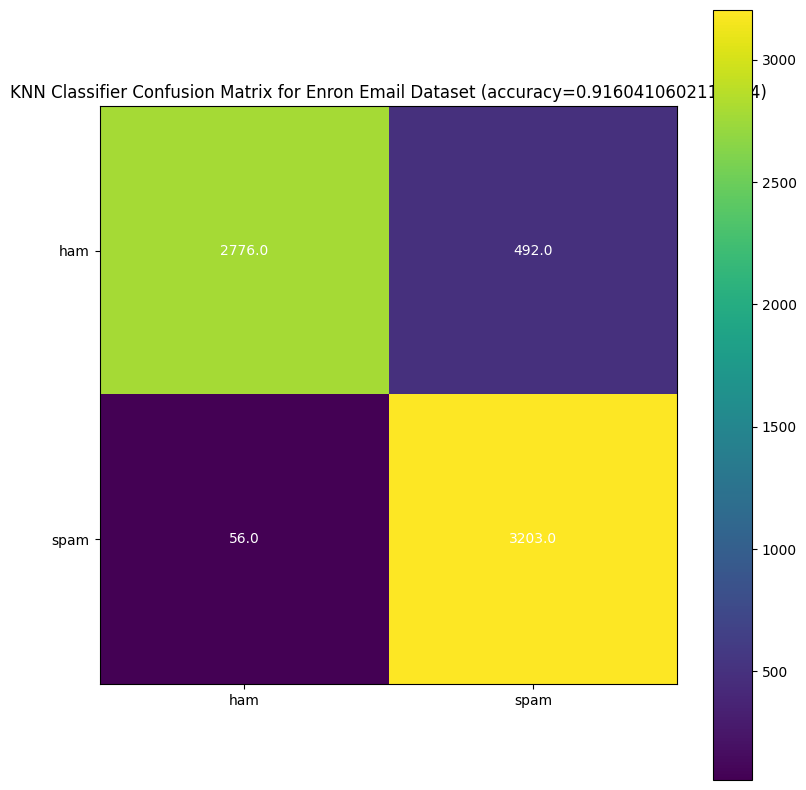

In [22]:
import matplotlib.pyplot as plt

visualize_confusion_matrix(nb_conf_matrix, ["ham", "spam"], f"Naive Bayes Classifier Confusion Matrix for Enron Email Dataset (accuracy={nb_accuracy})")
visualize_confusion_matrix(knn_conf_matrix, ["ham", "spam"], f"KNN Classifier Confusion Matrix for Enron Email Dataset (accuracy={knn_accuracy})")

### Observations and Conclusion
When using the original data preprocessing pipeline with no stopwords filtered from the dataset, the Naive Bayes classifier achieved an accuracy of $0.8890761452428374$ and the KNN classifier achieved an accuracy of $0.9149685920024514$.  
As shown in the above output however, when using the improved data preprocessing pipeline that fliters out stopwords from the dataset, the Naive Bayes classifier achieves an accuracy of $0.925846483836372$, representing a $4.14\%$ increase in model accuracy. The KNN classifier on the other hand achieves an accuracy of $0.9160410602114294$, representing a $0.12\%$ increase in model accuracy.

We also notice a decrease in both the number of false negatives and the number of false positives for the Naive Bayes classifier when stop words are filtered out from the dataset.  
However, for the KNN classifier, when stop words are filtered out, the decrease in the number of false negatives was accompanied by an increase in the number of false negatives.

Hence overall, filtering out stopwords from the dataset during data preprocessing, improved model performance especially for the Naive Bayes classifier but not as much for the KNN classifier.